In [213]:
#In this project, we group up the london boroughs by certain characteristics and pick top 5 from each group.
# We will then calculate the weekly cases per 100,000 for each region, which will be used to compare with the weekly london covid admission data. 
#The GOAL of this project is to find the characteristics that drives up hospital admissions.
# Using the characteristics we find in the end, we can locate the boroughs that need extra medical assistance.

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import linear_model
import statsmodels.api as sm

import geopandas as gpd

from datetime import datetime, timedelta

In [214]:
#retrieving the csv data on london borough population, cases, admissions, wage, etc.
pop = pd.read_csv('london_borough_population.csv')
pop = pop.rename(columns={"NAME": "area_name"})

#vaccination data
vaxRate = pd.read_csv('phe_vaccines_age_london_boroughs.csv')
dailyCase = pd.read_csv('phe_cases_london_boroughs.csv')
weekly_pay = pd.read_csv('london_weeklypay.csv')

#population data
populationData = pd.read_csv('london_population_ratio.csv')
populationData = populationData.drop(columns = ['Code', 'Year'])

#hospital admission data
admission_df = pd.read_csv('phe_healthcare_admissions_age.csv')
admission_df = admission_df.rename(columns={"week_ending": "date"})
# admission_df.set_index('date', inplace=True)

#demographic data from 2020.
demographic_df = pd.read_csv('demographic_london.csv')

fp = "london_shapefile/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp)
map_df = map_df.rename(columns={"NAME": "area_name"})
map_df = map_df.drop(columns = ['HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006'])


population_ratio = pd.merge(map_df, populationData, on='area_name')

size = 10

In [215]:
admission_df
admission_df = admission_df.groupby('date').sum()
admission_df

,age_lower,age_higher,weekly_admissions,weekly_rate
date,,,,
2020-03-21,174,255,537,88.6
2020-03-28,174,255,2759,417.4
2020-04-04,174,255,4535,606.8
2020-04-11,174,255,4516,713.4
2020-04-18,174,255,2687,442.1
...,...,...,...,...
2022-01-08,174,255,2410,366.8
2022-01-15,174,255,2065,338.7
2022-01-22,174,255,1742,286.7


In [216]:
demographic_df.head()

,area_code,area_name,White,Asian,Black,Mixed/ Other,Total,White%Population
0,E09000002,Barking and Dagenham,"99,000","55,000","51,000","16,000","222,000",45%
1,E09000003,Barnet,"255,000","79,000","28,000","35,000","398,000",64%
2,E09000004,Bexley,"188,000","20,000","28,000","18,000","254,000",74%
3,E09000005,Brent,"117,000","138,000","40,000","37,000","332,000",35%
4,E09000006,Bromley,"264,000","25,000","23,000","25,000","338,000",78%


In [217]:
#top boroughs with highest and lowest WEEKLY pay
highPay = weekly_pay.iloc[1:].sort_values('Weekly_Pay', ascending=False).head(size).rename(columns={"Area":"area_name"})
lowPay = weekly_pay.iloc[1:].sort_values('Weekly_Pay', ascending=False).tail(size).rename(columns={"Area":"area_name"})


#top 5 boroughs big and small population.
largePop = pop.sort_values('Population', ascending=False).head(size).rename(columns={"NAME":"area_name"})
smallPop = pop.sort_values('Population', ascending=False).tail(size).rename(columns={"NAME":"area_name"})


#top boroughs with highest and lowest male to female ratio. 
MFRatio_high = population_ratio[['area_name', 'M/F_ratio']].sort_values('M/F_ratio', ascending=False).head(size)
MFRatio_low = population_ratio[['area_name', 'M/F_ratio']].sort_values('M/F_ratio', ascending=False).tail(size)
MFRatio_high


#top boroughs with highest and lowest White population.
Whitepopulation_high = demographic_df[['area_name', 'White%Population']].sort_values('White%Population', ascending=False).head(size)
Whitepopulation_low = demographic_df[['area_name', 'White%Population']].sort_values('White%Population', ascending=False).tail(size)



#VAX RATE
#find the most recent data on 3rd dose vaccination.
recent = vaxRate.loc[vaxRate['date'] == '2022-02-21']

#Third Dose
third_dose = recent[['area_name', 'age_band', 'cum_doses', 'population']].loc[vaxRate['dose'] == '3rd dose'].groupby(by='area_name').sum()
third_dose['third_dose_rate'] = third_dose['cum_doses'] / third_dose['population']
third_dose = third_dose.drop(columns={'cum_doses', 'population'})


#top 5 borough with highest and lowest vax rate. Third Dose
highVaxRate_third = third_dose.sort_values('third_dose_rate', ascending=False).head(size)
lowVaxRate_third = third_dose.sort_values('third_dose_rate', ascending=False).tail(size)
highVaxRate_third.reset_index(inplace=True)
lowVaxRate_third.reset_index(inplace=True)


# Collect vaccination data on people under the age of 17, classified as young people.
third_dose_young = recent[['area_name', 'date', 'age_band', 'age_higher', 'cum_doses', 'population']].loc[vaxRate['dose'] == '3rd dose'].loc[recent['age_higher'] <= 17].groupby(by='area_name').sum().drop(columns={'age_higher'})
third_dose_young['third_dose_rate'] = third_dose_young['cum_doses'] / third_dose_young['population']
third_dose_young_high = third_dose_young.sort_values('third_dose_rate', ascending=False).head(size)
third_dose_young_low = third_dose_young.sort_values('third_dose_rate', ascending=False).tail(size)


#top boroughs with highest and lowest percentage of old people.
oldPopulation_high = population_ratio[['area_name', 'Old_rest_ratio']].sort_values('Old_rest_ratio', ascending=False).head(size)
oldPopulation_low = population_ratio[['area_name', 'Old_rest_ratio']].sort_values('Old_rest_ratio', ascending=False).tail(size)


Whitepopulation_low

,area_name,White%Population
9,Greenwich,54%
15,Hillingdon,49%
28,Tower Hamlets,49%
7,Ealing,47%
23,Newham,46%
0,Barking and Dagenham,45%
16,Hounslow,45%
24,Redbridge,42%
13,Harrow,41%
3,Brent,35%


In [218]:
#convert the daily Case data into daily case per 100,000 people. 
dailyCase_df = pd.merge(dailyCase, pop, on='area_name')
dailyCase_df['new_cases'] = dailyCase_df['new_cases'].div(dailyCase_df['Population'], axis=0)
dailyCase_df['new_cases'] = round(dailyCase_df['new_cases'] * 100000)
dailyCase_df = dailyCase_df.drop(columns=['Population'])

dailyCase_df.head()

,area_name,area_code,date,new_cases,total_cases
0,Barking and Dagenham,E09000002,2020-02-11,0.0,0
1,Barking and Dagenham,E09000002,2020-02-12,0.0,0
2,Barking and Dagenham,E09000002,2020-02-13,0.0,0
3,Barking and Dagenham,E09000002,2020-02-14,0.0,0
4,Barking and Dagenham,E09000002,2020-02-15,0.0,0


In [219]:
#merging the groups with dailyCase_df to collect data from ONLY  the boroughs in the groups.
#Then we group up the boroughs by date. We will compare each group on a collective basis.

new_cases_high_pay = pd.merge(dailyCase_df, highPay, on='area_name').groupby(by='date').sum().drop(columns=['total_cases', 'Unnamed: 2'])

new_cases_low_pay = pd.merge(dailyCase_df, lowPay, on='area_name').groupby(by='date').sum().drop(columns=['total_cases', 'Unnamed: 2'])

new_cases_small_pop = pd.merge(dailyCase_df, smallPop, on='area_name').groupby(by='date').sum().drop(columns=['total_cases', 'Population'])

new_cases_large_pop = pd.merge(dailyCase_df, largePop, on='area_name').groupby(by='date').sum().drop(columns=['total_cases', 'Population'])

new_cases_male_to_female_high = pd.merge(dailyCase_df, MFRatio_high, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','M/F_ratio'])

new_cases_male_to_female_low = pd.merge(dailyCase_df, MFRatio_low, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','M/F_ratio'])


new_cases_white_population_high = pd.merge(dailyCase_df, Whitepopulation_high, on='area_name').groupby(by='date').sum().drop(columns=['total_cases'])
new_cases_white_population_low = pd.merge(dailyCase_df, Whitepopulation_low, on='area_name').groupby(by='date').sum().drop(columns=['total_cases'])


new_cases_third_dose_high = pd.merge(dailyCase_df, highVaxRate_third, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','third_dose_rate'])
new_cases_third_dose_low = pd.merge(dailyCase_df, lowVaxRate_third, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','third_dose_rate'])


new_cases_third_dose_young_high = pd.merge(dailyCase_df, third_dose_young_high, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','third_dose_rate', 'population', 'cum_doses'])
new_cases_third_dose_young_low = pd.merge(dailyCase_df, third_dose_young_low, on='area_name').groupby(by='date').sum().drop(columns=['total_cases','third_dose_rate', 'population', 'cum_doses'])


new_cases_old_population_large = pd.merge(dailyCase_df, oldPopulation_high, on='area_name').drop(columns=['Old_rest_ratio'])
new_cases_old_population_large = new_cases_old_population_large.groupby(by='date').sum().rename(columns={"new_cases":"new_cases_largeOldPopulation"}).drop(columns= ['total_cases'])

new_cases_old_population_small = pd.merge(dailyCase_df, oldPopulation_low, on='area_name').drop(columns=['Old_rest_ratio'])
new_cases_old_population_small = new_cases_old_population_small.groupby(by='date').sum().rename(columns={"new_cases":"new_cases_smallOldPopulation"}).drop(columns= ['total_cases'])


In [220]:
#Converting daily data into weekly data, ending on Mondays. 
#This way, we can merge with the admission data, which was reported in weekly data ending on Monday

new_cases_high_pay.index = pd.to_datetime(new_cases_high_pay.index)
new_cases_low_pay.index = pd.to_datetime(new_cases_low_pay.index)
new_cases_small_pop.index = pd.to_datetime(new_cases_small_pop.index)
new_cases_large_pop.index = pd.to_datetime(new_cases_large_pop.index)
new_cases_male_to_female_high.index = pd.to_datetime(new_cases_male_to_female_high.index)
new_cases_third_dose_high.index = pd.to_datetime(new_cases_third_dose_high.index)
new_cases_third_dose_low.index = pd.to_datetime(new_cases_third_dose_low.index)
new_cases_third_dose_young_high.index = pd.to_datetime(new_cases_third_dose_young_high.index)
new_cases_third_dose_young_low.index = pd.to_datetime(new_cases_third_dose_young_low.index)
new_cases_old_population_large.index = pd.to_datetime(new_cases_old_population_large.index)
new_cases_old_population_small.index = pd.to_datetime(new_cases_old_population_small.index)

new_cases_white_population_high.index = pd.to_datetime(new_cases_white_population_high.index)
new_cases_white_population_low.index = pd.to_datetime(new_cases_white_population_high.index)


weeklyCase_highPay = new_cases_high_pay.resample('W-Sat').sum().iloc[1:]
weeklyCase_lowPay = new_cases_low_pay.resample('W-Sat').sum().iloc[1:]
new_cases_small_pop = new_cases_small_pop.resample('W-Sat').sum().iloc[1:]
new_cases_large_pop = new_cases_large_pop.resample('W-Sat').sum().iloc[1:]
new_cases_male_to_female_high = new_cases_male_to_female_high.resample('W-Sat').sum().iloc[1:]
new_cases_third_dose_high = new_cases_third_dose_high.resample('W-Sat').sum().iloc[1:]
new_cases_third_dose_low = new_cases_third_dose_low.resample('W-Sat').sum().iloc[1:]
new_cases_third_dose_young_high = new_cases_third_dose_young_high.resample('W-Sat').sum().iloc[1:]
new_cases_third_dose__young_low = new_cases_third_dose_young_low.resample('W-Sat').sum().iloc[1:]
new_cases_old_population_large = new_cases_old_population_large.resample('W-Sat').sum().iloc[1:]
new_cases_old_population_small = new_cases_old_population_small.resample('W-Sat').sum().iloc[1:]

new_cases_white_population_high = new_cases_white_population_high.resample('W-Sat').sum().iloc[1:]
new_cases_white_population_low = new_cases_white_population_low.resample('W-Sat').sum().iloc[1:]

new_cases_white_population_high

,new_cases
date,
2020-02-22,0.0
2020-02-29,2.0
2020-03-07,13.0
2020-03-14,105.0
2020-03-21,209.0
...,...
2022-01-15,9407.0
2022-01-22,9675.0
2022-01-29,9662.0


In [221]:
weeklyCase_highPay.index = weeklyCase_highPay.index.astype(str)
weeklyCase_lowPay.index = weeklyCase_lowPay.index.astype(str)
new_cases_small_pop.index = new_cases_small_pop.index.astype(str)
new_cases_large_pop.index = new_cases_large_pop.index.astype(str)
new_cases_male_to_female_high.index = new_cases_male_to_female_high.index.astype(str)
new_cases_male_to_female_low.index = new_cases_male_to_female_low.index.astype(str)
new_cases_third_dose_high.index = new_cases_third_dose_high.index.astype(str)
new_cases_third_dose_low.index = new_cases_third_dose_high.index.astype(str)
new_cases_third_dose_young_high.index = new_cases_third_dose_young_high.index.astype(str)
new_cases_third_dose_young_low.index = new_cases_third_dose_young_low.index.astype(str)


new_cases_old_population_large.index = new_cases_old_population_large.index.astype(str)
new_cases_old_population_small.index = new_cases_old_population_small.index.astype(str)

new_cases_white_population_high.index = new_cases_white_population_high.index.astype(str)
new_cases_white_population_low.index = new_cases_white_population_high.index.astype(str)


In [222]:
#renaming columns.

weeklyCase_highPay = weeklyCase_highPay.rename(columns={'new_cases':'new_cases_high_pay'})
weeklyCase_lowPay = weeklyCase_lowPay.rename(columns={'new_cases':'new_cases_low_pay'})
new_cases_small_pop = new_cases_small_pop.rename(columns={'new_cases':'new_cases_small_pop'})
new_cases_large_pop = new_cases_large_pop.rename(columns={'new_cases':'new_cases_large_pop'})
new_cases_male_to_female_high = new_cases_male_to_female_high.rename(columns={'new_cases':'new_cases_male_to_female_high'})
new_cases_male_to_female_low = new_cases_male_to_female_low.rename(columns={'new_cases':'new_cases_male_to_female_low'})
new_cases_third_dose_high = new_cases_third_dose_high.rename(columns={'new_cases':'new_cases_third_dose_high'})
new_cases_third_dose_low = new_cases_third_dose_low.rename(columns={'new_cases':'new_cases_third_dose_low'})

new_cases_third_dose_young_high = new_cases_third_dose_young_high.rename(columns={'new_cases':'new_cases_third_dose_young_high'})
new_cases_third_dose_young_low = new_cases_third_dose_young_low.rename(columns={'new_cases':'new_cases_third_dose_young_low'})


new_cases_old_population_large = new_cases_old_population_large.rename(columns={'new_cases':'new_cases_old_to_rest_high'})
new_cases_old_population_small = new_cases_old_population_small.rename(columns={'new_cases':'new_cases_old_to_rest_low'})

new_cases_white_population_high = new_cases_white_population_high.rename(columns={'new_cases':'new_cases_white_population_high'})
new_cases_white_population_low = new_cases_white_population_low.rename(columns={'new_cases':'new_cases_white_population_low'})

In [223]:
#monthly admission data
monthlyAdmission = admission_df.drop(columns={'age_lower', 'age_higher', 'weekly_rate'}).reset_index(drop=False)
monthlyAdmission

,date,weekly_admissions
0,2020-03-21,537
1,2020-03-28,2759
2,2020-04-04,4535
3,2020-04-11,4516
4,2020-04-18,2687
...,...,...
94,2022-01-08,2410
95,2022-01-15,2065
96,2022-01-22,1742
97,2022-01-29,1449


In [224]:
#creating a new dataframe, merging it with monthly_admission dataframe for multi linear regression.

combo = pd.merge(weeklyCase_highPay, weeklyCase_lowPay, on='date')
# combo = pd.merge(combo, new_cases_small_pop, on='date')
combo = pd.merge(combo, new_cases_large_pop, on='date')
combo = pd.merge(combo, new_cases_male_to_female_high, on='date')
combo = pd.merge(combo, new_cases_third_dose_high, on='date')
combo = pd.merge(combo, new_cases_third_dose_low, on='date')
combo = pd.merge(combo, new_cases_third_dose_young_high, on='date')
combo = pd.merge(combo, new_cases_third_dose_young_low, on='date')
combo = pd.merge(combo, new_cases_old_population_large, on='date')
combo = pd.merge(combo, new_cases_old_population_small, on='date')
combo = pd.merge(combo, new_cases_white_population_high, on='date')
combo = pd.merge(combo, new_cases_white_population_low, on='date')

combo = pd.merge(combo, monthlyAdmission, on='date')

In [225]:
#For regression, we will look at the weekly cases in each boorugh change in percentage and whether it has an effect
#on percentage change in weekly hospital admissions.

combo.set_index('date', inplace=True)
combo = combo.pct_change().iloc[1:]
combo.head()

,new_cases_high_pay,new_cases_low_pay,new_cases_large_pop,new_cases_male_to_female_high,new_cases_third_dose_high,new_cases_third_dose_low,new_cases_third_dose_young_high,new_cases_third_dose_young_low,new_cases_largeOldPopulation,new_cases_smallOldPopulation,new_cases_white_population_high,new_cases_white_population_low,weekly_admissions
date,,,,,,,,,,,,,
2020-03-28,1.118367,1.261603,1.181818,1.004854,1.253165,1.209302,1.062044,0.735294,1.531915,0.936709,1.215311,0.975904,4.137803
2020-04-04,0.175337,0.337687,0.266667,0.377724,0.230337,0.328947,0.185841,0.355932,0.258403,0.374728,0.336933,0.357724,0.643711
2020-04-11,-0.214754,-0.143654,-0.171053,-0.172232,-0.088280,-0.126733,-0.123881,-0.375000,-0.071786,-0.190174,-0.159935,-0.115269,-0.004190
2020-04-18,-0.286013,-0.133550,-0.274603,-0.309979,-0.096828,-0.294785,-0.218058,-0.340000,-0.163669,-0.379648,-0.192308,-0.252115,-0.405004
2020-04-25,-0.228070,-0.293233,-0.284464,-0.289231,-0.258780,-0.276527,-0.172113,-0.242424,-0.251613,-0.328076,-0.197619,-0.223982,-0.372907


In [226]:
x = combo.drop(['weekly_admissions'],axis=1)
y = combo['weekly_admissions']

In [227]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      weekly_admissions   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     8.923
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           8.59e-11
Time:                        15:51:56   Log-Likelihood:                -32.857
No. Observations:                  98   AIC:                             91.71
Df Residuals:                      85   BIC:                             125.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [228]:
#looking at how each cluster performs vs weekly_admission.
significant = combo[['weekly_admissions', 'new_cases_low_pay', 'new_cases_largeOldPopulation']]

graph = px.line(significant, x=significant.index, y=list(significant))
graph

graph.update_layout(
    title='Weekly Covid19 Cases % Change vs. Hospitalization % Change',
    xaxis_title="Week",
    yaxis_title="Percentage Change",
    legend_title="Cluster Groups",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="RebeccaPurple"
    )
)

In [229]:
#finding boroughs with overlapping characteristics.

mix = pd.merge(lowPay, oldPopulation_high, on='area_name').drop(columns={'Unnamed: 2'})
mix

,area_name,Weekly_Pay,Old_rest_ratio
0,Sutton,650.6,0.181557
1,Barnet,616.9,0.170668


(-0.5525946011260483,
 0.37623509511498954,
 51.26650445816394,
 51.71212980719948)

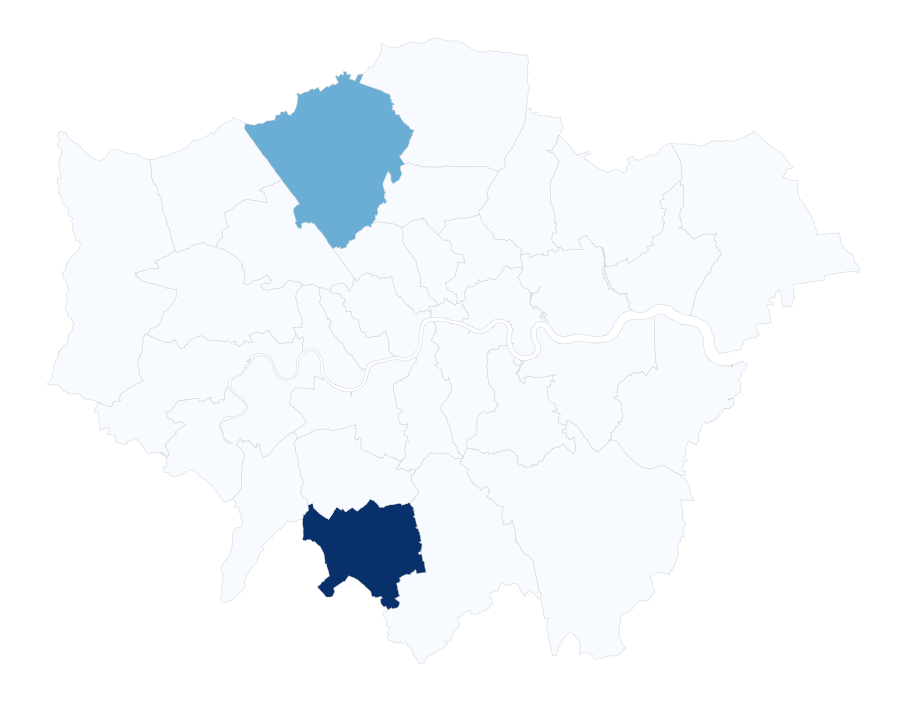

In [230]:
#making a graph showing the boroughs with overlapping characteristics.

import matplotlib.pyplot as plt

# # create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(16,16))


fp = "london_shapefile/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp)
map_df = map_df[['NAME', 'geometry']]
map_df.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
map_df = map_df.rename(columns={"NAME": "area_name"})

g = map_df.merge(mix, on='area_name', how='outer')
g['Weekly_Pay'] = g['Weekly_Pay'].fillna(0)
g

#plot the map of london
sc = g.plot(column='Weekly_Pay', cmap="Blues", linewidth=0.4, ax=ax, edgecolor='0.8')
sc

ax.axis('off')